# Założenia
Celem projektu jest stworzenie skryptu generującego profil terenu z cyfrowego modelu terenu (DEM) w formacie (Geo)Tiff dla linii o zadanym punkcie początkowym, długości i azymucie.

Realizacja zadania będzie wymagała następujących etapów:

1. Określenie linii przekroju.
    1. Wyznaczenie funkcji liniowej o zadanym współczynniku kierunkowym (wyrażonym przez tangens kąta azymutu).
    2. Rozwiązanie problemów z zapisem kąta azymutu.
2. Wczytanie modelu terenu.
3. Odczytanie wysokości wzdłuż zdefiniowanej linii profilu.
4. Wykreślenie profilu.

## 1. Import modułów

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import rasterio

## 2. Linia przekroju
Ogólne równanie prostej to *y = ax + b*, gdzie:
    *a*: współczynnik kierunkowy prostej, *a = tan(alfa)*, gdzie:
        *alfa* - kąt nachylenia prostej do osi x
    *b*: określa przesunięcie prostej wzdłuż osi y; na razie przyjmiemy *b=0*

Trzy funkcje poniżej służą do: 
1. rysowania linii o zadanych współczynnikach
2. obliczania współczynnika kierunkowego dla prostej o zadanym azymucie
3. rysowaniu linii o zadanym azymucie.

In [2]:
def rysuj_linie(a = 1, b = 0):
    '''
    Rysuje prostą o zadanych współczynnikach a, b.
    '''
    x = np.linspace(1,10)
    y = a * x + b
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.axis('equal')
    plt.show()

In [3]:
def wsp_kier_z_azymutu(azymut):
    '''
    Określa współczynnik kierunkowy prostej o danym azymucie
    
    Args:
        azymut (int): azymut prostej, w stopniach
        
    Returns:
        float: współczynnik kierunkowy prostej
    
    '''
    if azymut > 180:
        azymut -= 180
    alfa = 90 - azymut
    alfa = (alfa * np.pi)/180
    return(np.tan(alfa))

In [4]:
def linia_z_azymutu(azymut):
    '''
    Rysuje prostą o zadanym azymucie
    '''
    a = wsp_kier_z_azymutu(azymut)
    rysuj_linie(a)

Testowanie funkcji

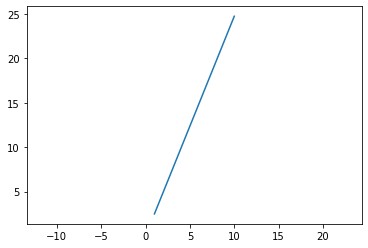

In [5]:
linia_z_azymutu(22)

## 3. Wczytywanie i wyświetlanie modelu

Do otwarcia rastra z georeferencjami służy funkcja *open* z modułu *rasterio*, a więc dostęp do niej mamy wywołaniem *rasterio.open()* Funkcja ta nie wczytuje rastra, tworzy tylko do niego dowiązanie, które nazwiemy *src*. Następnie, po otwarciu rastra musimy go wczytać do zmiennej *dem*, za pomocą funkcji read. Warto zauważyć, że *read* jest już funkcją (metodą) utworzonego dowiązania do rastra o nazwie *src*.

Finalna zmienna, *dem* jest typu ndarray, pochodzącego z modułu numpy; jest to więc typ przechowujący macierz. I faktycznie - obraz jest przecież macierzą 👀.

In [6]:
plik_rastra = 'dem.tif'

In [7]:
with rasterio.open(plik_rastra) as src:
    dem = src.read(1)

In [8]:
type(dem)

numpy.ndarray

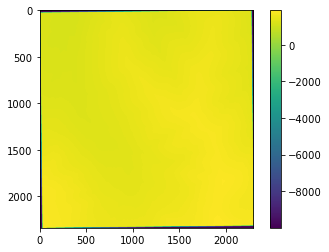

In [9]:
plt.imshow(dem)
plt.colorbar()

Jak widać, udało się, ale zakres wysokości jest od prawie że Rowu Mariańskiego do nieco ponad 0. Wynika to z tego, że w użytych danych jako -9999 zakodowany jest brak danych.

Skąd braki danych?
Każdy raster musi być prostokątem ułożonym równolegle do osi układu współrzędnych. Model natomiast jest w formie "kafelków" które są nieco zrotowane względem tego układu, stąd przy krawędziach pojawiają się wąziutkie kliny z brakiem danych.

Otworzymy teraz jeszcze raz plik, ustawiając maskowanie wartości -9999.

In [10]:
with rasterio.open(plik_rastra,'r+') as src:
    src.nodata = -9999
    dem = src.read(1,masked=True)

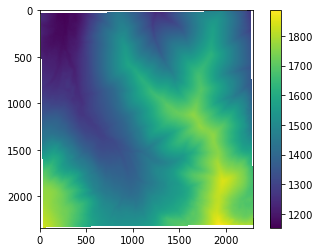

In [11]:
plt.imshow(dem)
plt.colorbar()

Układ współrzędnych

In [12]:
with rasterio.open(plik_rastra,'r+') as src:
    src.nodata = -9999
    dem.crs = rasterio.crs.CRS.from_epsg(2180)




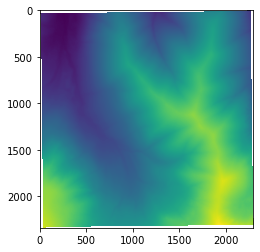

In [13]:
plt.imshow(dem)

## 4. Odczytujemy dane z modelu

Możemy teraz sprawdzić wysokość dowolnego punktu w obszarze naszego rastra podając jego współrzędne. Póki co pracujemy w lokalnym układzie współrzędnych, powiązanych z danym rastrem - zignorowaliśmy w jakim układzie współrzędnych nasz raster jest tak naprawdę (a jest to układ 19... o kodzie EPSG 21... - to już wiecie sami!)

In [14]:
x = 100
y = 1242

dem[x,y]

1280.16

In [15]:
type(dem)

numpy.ma.core.MaskedArray

Możemy nawet dodać nieco interaktywności:

In [16]:
n

NameError: name 'n' is not defined

In [17]:
sprawdz_wysokosc(dem)

NameError: name 'sprawdz_wysokosc' is not defined

Dzięki temu, że model przekazujemy do naszej funkcji jako argument, można ją wygodnie wykorzystać wielokrotnie - możemy np. mieć kilka modeli o różnych nazwach i na każdym z nich wywoływać *sprawdz_wysokosc*.
Wprowadzanie danych umożliwia funkcja *input*, opakowanie w funkcję *int* służy przekształceniu (zrzutowaniu) wprowadzanych danych na liczbę całkowitą (tylko taka może być użyta jako indeks macierzy)

## Czytamy dane wzdłuż zadanej linii azymutu

Dla uniknięcie problemów, nasze azymuty niech należą do przedziału (0 - 90) stopni. Później będziemy poprawiać nasze rozwiązania tak, aby można je stosować dla dowolnego przypadku.

Ze zdefiniowanych na początku funkcji wykorzystamy tylko *wsp_kier_z_azymutu*. Przypomnijmy sobie co ona robi.

In [ ]:
help(wsp_kier_z_azymutu)

### Współrzędne punktów wzdłuż prostej

Będziemy potrzebować funkcję - w sensie programistycznym - definiującą funkcję w sensie matematycznym... Brzmi skomplikowanie, ale chodzi nam po prostu o funkcję która kolejnym punktom wzdłuż naszej linii przekroju, przyporządkuje wartości z (wysokości).

In [1]:
def punkty_wzdluz_linii (x0, y0, d, dlugosc, azymut):
    '''
    oblicza współrzędne punktów wzdłuż linii o zadanym azymucie.
    Args:
        x0 (int): współrzędna x początku linii
        y0 (int): współrzędna y początku linii
        d (float): odległość między punktami
        dlugosc: łączna długość linii wzdłuż której wyznaczamy punkty
        azymut: azymut linii w stopniach
        
    Returns:
        list: 3-elementowa lista:
            punkty_xy[0] - współrzędne x
            punkty_xy[1] - współrzędne y
            punkty_xy[2] - odległości od początku profilu
    '''
   
    a = wsp_kier_z_azymutu(azymut)
    
    dystans = 0
    punkty_x = [x0]
    punkty_y = [y0]
    punkty_d  = [0]
    
    old_x = x0
    old_y = y0
    
    dx = (d / np.sqrt(1 + a**2))
    dy = a * dx
    
    
    while (dystans < dlugosc):
        new_x = old_x + dx
        new_y = old_y + dy
        
        punkty_x.append(new_x)
        punkty_y.append(new_y)
        punkty_d.append(dystans)
        
        dystans += d
        
        old_x = new_x
        old_y = new_y
    
    return((punkty_x,punkty_y,punkty_d))    

**Jak działa powyższa funkcja?**

Najpierw z azymutu oblicza współczynnik kierunkowy. Następnie zapisuje początkowe współrzędne do list *punkt_x*, *punkt_y*.

Zmienne *dx*, *dy* to przyrosty współrzędnych x, y dla danego dystansu *d*.

Pętla oblicza przyrosty dla kolejnych par punktów (oznaczonych *old_x*, *old_y*), dodaje wyniki do list a następnie podmienia wartości old... (z poprzedniej iteracji) na wartości new... (z bieżącej iteracji).

Ponieważ w każdej iteracji przemieszczamy się o odległość d, dodajemy tę odległość do zmiennej dystans mierzącej całkowity przebieg. Ponadto, narastającą odległość zapisujemy również do listy i zwracamy w wyniku funkcji. Zauważ, że wynikiem tej funkcji jest trzyelementowa tzw. krotka (ang. _tuple_), na którą składają się trzy listy. Zamiast krotki moglibyśmy użyć też listy.

### Testujemy!
Przetestujmy funkcję punkty_wzdluz_linii. Najpierw obliczymy i wyświetlimy serię punktów, potem zaokrąglimy wynik do liczb całkowitych (0 miejsc po przecinku), bo tylko takie wartości będziemy mogli wykorzystać. Korzystamy z funkcji np.round, bo chcemy zaokrąglić zgodnie z zasadami, a nie po prostu obciąć część dziesiętną, zresztą, zobacz co się dzieje w komórce niżej: 

In [26]:
#kod pokazowy, nie ma znaczenia dla całego projektu
pokaz = 1.62
print(int(pokaz))
print(np.round(pokaz,0))

1
2.0


In [27]:
p = punkty_wzdluz_linii(x0 = 1000, y0 = 1000, d= 10, dlugosc=100,azymut=30)

In [28]:
p[0]

[1000,
 1005.0,
 1010.0,
 1015.0,
 1020.0,
 1025.0,
 1030.0,
 1035.0,
 1040.0,
 1045.0,
 1050.0]

In [29]:
p[1]

[1000,
 1008.6602540378444,
 1017.3205080756888,
 1025.9807621135333,
 1034.6410161513777,
 1043.3012701892221,
 1051.9615242270665,
 1060.621778264911,
 1069.2820323027554,
 1077.9422863405998,
 1086.6025403784442]

A więc mamy dwie listy liczb. Są one póki co typu float, ale to nie będzie problem. W każdym razie, wygląda na to, że funkcja działa.

### Odczytujemy wartości z (wysokości) wzdłuż zadanych punktów

Oczywiście, zrobimy do tego funkcję.

In [30]:
def czytaj_wysokosci(punkty_xy,dem):
    '''
    Odczytuje wysokości w zadanych punktach o współrzędnych x, y z modelu terenu dem.
    
    Args:
        punkty_xy (list): punkty wzdłuż prostej
        dem (np.array): model terenu w formie macierzy
        
    Returns:
        list: lista [d,z] gdzie:
                    d - narastająca odległość wzdłuż linii profilu
                    z - wysokość
    '''
    
    punkty_z = []
    
    punkty_x = list(np.round(punkty_xy[0],0))
    punkty_y = list(np.round(punkty_xy[1],0))
    punkty_d = list(punkty_xy[2]) #z tym nie będziemy nic robić, przekażemy tylko do zwracanej listy
    
    for x, y in zip(punkty_x, punkty_y):
        z = dem[int(x),int(y)]
        punkty_z.append(z)
    return ([punkty_d,punkty_z,])

In [31]:
pz = czytaj_wysokosci(p,dem)

## Rysujemy profil!
Argumentem funkcji rysującej profil będzie lista zwracana przez funkcję *czytaj_wysokosc*.

In [32]:
def rysuj_profil(dane):
    profil, ax = plt.subplots()
    ax.plot(dane[1],dane[0])
    plt.xlabel("Odległość [m]")
    plt.ylabel("Wysokość [m n.p.m.]")
    profil.show()

C:\Users\M Kania User\AppData\Local\Temp\ipykernel_18072\972619722.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  profil.show()


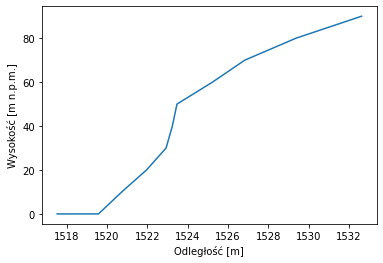

In [33]:
rysuj_profil(pz)

Funkcja rysuj_profil działa, ale wymaga ulepszeń, zdefiniujmy ją raz jeszcze:

In [34]:
def rysuj_profil(dane):
    profil, ax = plt.subplots()
    ax.plot(dane[0],dane[1])
    plt.xlabel("Odległość [m]")
    plt.ylabel("Wysokość [m n.p.m.]")
    
    plt.axis('scaled')
    xsize = 10
    ysize = xsize/2
    plt.figure(figsize=(xsize,ysize),dpi=300)
    profil.show()

C:\Users\M Kania User\AppData\Local\Temp\ipykernel_18072\1870465786.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  profil.show()


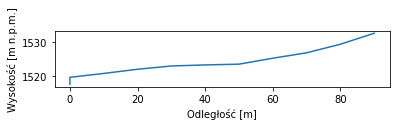

<Figure size 3000x1500 with 0 Axes>

In [35]:
rysuj_profil(pz)

## Zbierzmy teraz całość do kupy

Wygenerujemy profil terenu wzdłuż jakiejś innej linii. Będziemy musieli skorzystać kolejno z trzech zdefiniowanych wcześniej funkcji:
1. *punkty_wzdluz_linii()*
2. *czytaj_wysokosci()*
3. *rysuj_profil()*

Całą komórkę zrobimy znów interaktywnie.

In [ ]:
x = int(input("Współrzędna x początku profilu:"))
y = int(input("Współrzędna y początku profilu:"))
dlugosc = int(input("Długość profilu (w metrach):"))
azymut = int(input("Azymut linii (w stopniach)"))

pxy = punkty_wzdluz_linii(x0 = x, y0 = y, d = 10, dlugosc = dlugosc, azymut = azymut)
pdz = czytaj_wysokosci(punkty_xy = pxy, dem = dem)
rysuj_profil(dane = pdz)

## Co dalej?

Nasze funkcje, póki co, są zupełnie nieodporne na możliwe błędy, np. podanie zbyt długiej linii. Należałoby teraz zaprogramować sprawdzanie odpowiednich warunków, np. że współrzędne x, y linii nie mogą przekroczyć maksymalnych wartości x, y rastra.

Kolejną rzeczą, którą możemy zrobić to przekopiowanie wszystkich funkcji do osobnego pliku i wykorzystywanie go jako własnego modułu, który będziemy mogli importować.

# KONIEC (części 1?)